In [ ]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'pytorch'

In [ ]:
import deepxde as dde
import matplotlib.pyplot as plt 
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/userhome/jeon_mg/miniforge3/envs/deepxde/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [ ]:
# Poisson equation: -u_xx =f 
def equation(x, y, f):
    dy_xx = dde.grad.hessian(y, x)
    return -dy_xx -f 

In [ ]:
# Domain is interval [0, 1]
geom = dde.geometry.Interval(0, 1)

In [ ]:
# Zero Dirichlet BC
def u_boundary(_):
    return 0

def boundary(_, on_boundary):
    return on_boundary

bc = dde.icbc.DirichletBC(geom, u_boundary, boundary)

In [ ]:
# Define PDE
pde = dde.data.PDE(geom, equation, bc, num_domain=100, num_boundary=2)

In [ ]:
# Function space for f(x) are polynomials
degree = 3
space = dde.data.PowerSeries(N=degree + 1)

In [ ]:
# Choose evaluation points
num_eval_points = 10
evaluation_points = geom.uniform_points(num_eval_points, boundary=True)

In [ ]:
# Define PDE operator
pde_op = dde.data.PDEOperatorCartesianProd(
    pde,
    space,
    evaluation_points,
    num_function=100
)

In [ ]:
# Setup DeepONet
dim_x = 1
p = 32
net = dde.nn.DeepONetCartesianProd(
    [num_eval_points, 32, p],
    [dim_x, 32, p],
    activation = "tanh",
    kernel_initializer="Glorot normal"
)

In [ ]:
# Define and train model
model = dde.Model(pde_op, net)
dde.optimizers.set_LBFGS_options(maxiter=1000)
model.compile("L-BFGS")
model.train()

Compiling model...
'compile' took 0.266550 s

Training model...

Step      Train loss              Test loss               Test metric
0         [8.45e-01, 2.97e-01]    [8.45e-01, 2.97e-01]    []  
1000      [8.74e-06, 4.19e-07]    [8.74e-06, 4.19e-07]    []  

Best model at step 1000:
  train loss: 9.15e-06
  test loss: 9.15e-06
  test metric: []

'train' took 405.103250 s



(<deepxde.model.LossHistory>,
 <deepxde.model.TrainState>)

In [ ]:
# Plot realisations of f(x)
n = 3
features = space.random(n)
fx = space.eval_batch(features, evaluation_points)

x = geom.uniform_points(100, boundary=True)
y = model.predict((fx, x))

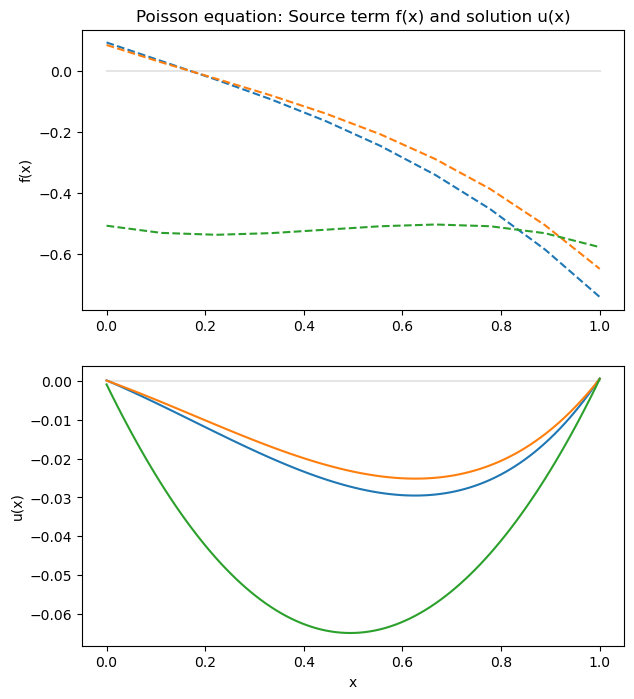

In [ ]:
# Setup figure
fig = plt.figure(figsize=(7, 8))
plt.subplot(2, 1, 1)
plt.title("Poisson equation: Source term f(x) and solution u(x)")
plt.ylabel("f(x)")
z = np.zeros_like(x)
plt.plot(x, z, "k-", alpha=0.1)

# Plot source term f(x)
for i in range(n):
    plt.plot(evaluation_points, fx[i], "--")

# Plot solution u(x)
plt.subplot(2, 1, 2)
plt.ylabel("u(x)")
plt.plot(x, z, "k-", alpha=0.1)
for i in range(n):
    plt.plot(x, y[i], "-")
plt.xlabel("x")

plt.show()